In [1]:
import os 
os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.9.0"

from matplotlib import pyplot as plt

from plio.io.io_gdal import GeoDataset 
import numpy as np

from glob import glob

from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from pysis.sugar import point_info
from autocnet.cg import change_detection as cd

from plio.io.io_gdal import GeoDataset
from pysis import isis
from pysis.exceptions import ProcessError

from IPython.display import display

import shutil

from autocnet.utils import hirise 
from autocnet.utils.utils import bytescale

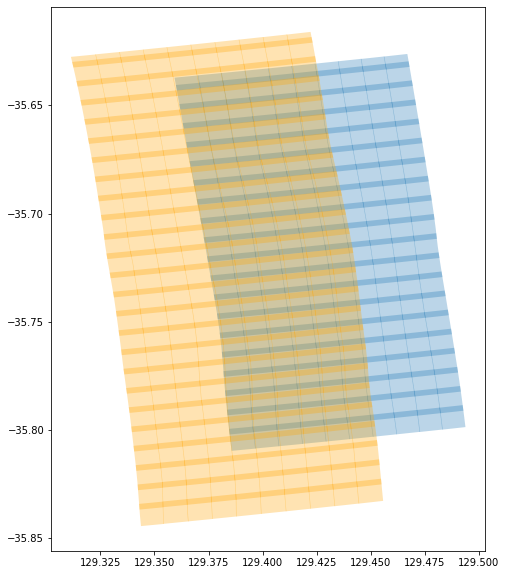

In [2]:
df1 = hirise.load_segments("/scratch/krodriguez/hirise/no_change/ESP_012024_1440/")
df2 = hirise.load_segments("/scratch/krodriguez/hirise/no_change/ESP_020661_1440/")

ax = df1.plot(figsize=(10,10), alpha=.3)
df2.plot(figsize=(20,50), alpha=.3, ax=ax, color="orange")

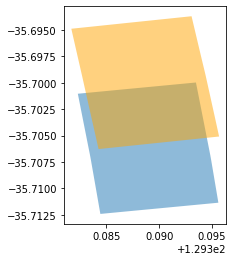

In [3]:
p = Point(129.393, -35.703)

roi1 = df1[df1.intersects(p)].reindex()
roi1_geoms = roi1["footprint"]

roi2 = df2[df2.intersects(roi1.footprint.unary_union)]
roi2 = roi2[roi2.intersects(p)].iloc[0:1]


ax = roi1.plot(alpha=.5)
roi2.plot(ax=ax, alpha=.5, color="orange")

roi1 = roi1.iloc[0]
roi2 = roi2.iloc[0]

In [4]:
new_dir = '/tmp/'

roi1_path = os.path.join(new_dir, os.path.basename(roi1.path))
roi2_path = os.path.join(new_dir, os.path.basename(roi2.path))

shutil.copyfile(roi1.path, roi1_path)
shutil.copyfile(roi2.path, roi2_path)

with open("/tmp/test.lis", "w") as f:
    f.write("\n".join([roi1_path, roi2_path]))

In [5]:
%%time
#Point to the adjacency Graph
adjacency = {roi1_path: [roi2_path], roi2_path: [roi1_path]}

cg = CandidateGraph.from_adjacency(adjacency)

#Apply SIFT to extract features
cg.extract_features(extractor_method='vlfeat', extractor_parameters={'nfeatures':100})
cg.match()

# Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
cg.minimum_spanning_tree()

# Compute a homography and apply RANSAC
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])

/home/krodriguez/.conda/envs/autocnetdev/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


CPU times: user 33.9 s, sys: 716 ms, total: 34.6 s
Wall time: 34.6 s


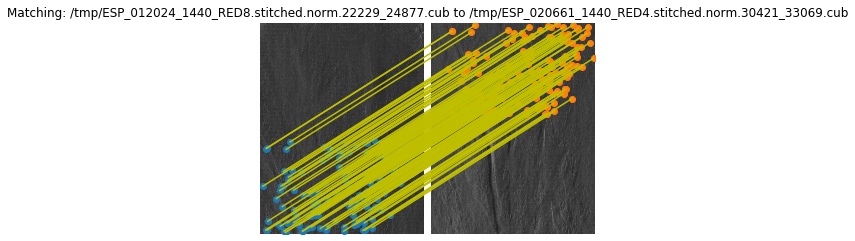

In [16]:
cg[1][2]["data"].plot(clean_keys=["fundamental"])

In [7]:
cg.generate_control_network(clean_keys=["fundamental"])
cg.to_isis("test.net")

In [8]:
cat test.lis

/tmp/ESP_020661_1440_RED4.stitched.norm.30421_33069.cub
/tmp/ESP_012024_1440_RED8.stitched.norm.22229_24877.cub


In [9]:
try:
    output = isis.jigsaw(fromlist='test.lis', cnet='test.net', onet='bundle_test.cnet', update='yes', radius='yes', errorpropagation='yes', outlier_rejection='yes', point_longitude_sigma=10, point_latitude_sigma=10, point_radius_sigma=2, maxits=20, camsolve='VELOCITIES', twist='yes', overexisting='yes', spsolve='NONE')
    print(output.decode())
except ProcessError as e:
    print(e.stderr)


Validating network...
Validation complete!...
starting iteration 1



median deviation: 0.428527

mad: 0.635334

Rejection Limit: 2.73574


Rejected Observations:0 (Rejection Limit:2.73574)

Measures that came back: 0
Iteration: 1 
Sigma0:         0.7409386686 
Observations: 636 
Constrained Parameters:477 
Unknowns: 489 
Degrees of Freedom: 624 
End of Iteration 1 
Elapsed Time:         0.0200000000 
Group = Iteration1
  Sigma0                       = 0.74093866855463
  Observations                 = 636
  Constrained_Point_Parameters = 477
  Constrained_Image_Parameters = 0
  Unknown_Parameters           = 489
  Degrees_of_Freedom           = 624
  Rejected_Measures            = 0
End_Group
starting iteration 2



median deviation: 0.46773

mad: 0.693457

Rejection Limit: 2.98239


Rejected Observations:0 (Rejection Limit:2.98239)

Measures that came back: 0
Iteration: 2 
Sigma0:         0.6506659496 
Observations: 636 
Constrained Parameters:477 
Unknowns: 489 
Degrees of Freedom: 

In [10]:
roi1_proj = os.path.splitext(roi1_path)[0] + ".proj.cub"
roi2_proj = os.path.splitext(roi2_path)[0] + ".proj.cub"

try:
    isis.cam2map(from_=roi1_path, to=roi1_proj, map='/usgs/cpkgs/isis3/data/base/templates/maps/equirectangular.map')
    isis.cam2map(from_=roi2_path, to=roi2_proj, patchsize=8, map=roi1_proj, matchmap=True, warpalgorithm="REVERSEPATCH")
except ProcessError as e:
    print(e.stderr)

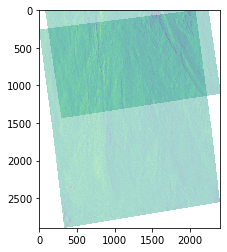

In [17]:
import pysis
roi1_proj_geo = GeoDataset(roi1_proj)
roi2_proj_geo = GeoDataset(roi2_proj)
isis_null = pysis.specialpixels.SPECIAL_PIXELS['Real']['Null']

proj_array1 = roi1_proj_geo.read_array()
proj_array2 = roi2_proj_geo.read_array()

proj_array1[proj_array1 == isis_null] = np.nan
proj_array2[proj_array2 == isis_null] = np.nan

plt.imshow(proj_array1, alpha=.4)
plt.imshow(proj_array2, alpha=.4)


In [14]:
# apply change detection algo
polys, weights, diffarr = cd.okubogar_detector(roi1_proj_geo, roi2_proj_geo)

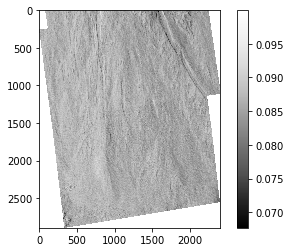

In [19]:
import matplotlib

plt.imshow(proj_array1, cmap="Greys_r")
plt.imshow(proj_array2, cmap="Greys_r")

if weights:
    cmap = matplotlib.cm.get_cmap('plasma')
    colors = bytescale(np.asarray(weights))
    ax = [plt.fill(*p.exterior.xy, c=cmap(colors[i]), alpha=.6) for i,p in enumerate(polys)]
plt.colorbar()

plt.show()
